# Análise Exploratória dos Dados da Base MIMIC-III

O MIMIC (Medical Information Mart for Intensive Care) é um grande banco de dados disponível gratuitamente que inclui dados relacionados à saúde não identificados de pacientes que foram admitidos nas unidades de cuidados intensivos do Beth Israel Deaconess Medical Center.

O MIMIC é composto por dados coletados de dois sistemas de informações clínicas diferentes: CareVue e MetaVision.

Nesta versão da base MIMIC temos atendimentos efetuados de **01/06/2001** a **10/10/2012**.

Número de atendimentos: **58.976**

Número de pacientes atendidos: **46.520**

## Objetivo
Entender como são os elementos desta base para aproveitar esta oportunidade concedida pela disciplina de iniciar o estudo de caso da minha dissertação com uma base de dados médicos reais e utilizada em diversos trabalhos de pesquisa.

## Análise

Imports das bibliotecas

In [49]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

### Pacientes

Número de pacientes

In [312]:
patients_df = pd.read_csv('C:\csvMimic\\v1_4\PATIENTS.csv', usecols=['SUBJECT_ID', 'GENDER', 'DOB', 'EXPIRE_FLAG'])
patients_df.shape[0]

46520

Número de pacientes por gênero

In [77]:
patients_df['GENDER'].value_counts()

M    26121
F    20399
Name: GENDER, dtype: int64

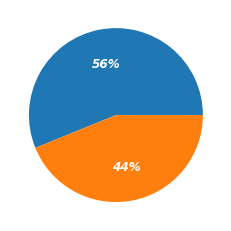

In [314]:
labels_gender = ['Homens', 'Mulheres']
plt.pie(patients_df['GENDER'].value_counts(), labels = labels_gender, autopct='%.0f%%', textprops={'fontsize': 12, 'color': 'white', 'style': 'oblique', 'weight': 'bold'})
plt.show()

Temos que a quantidade de homens e mulheres é próxima, sem grande disparidade.

Qual a taxa de sobrevivência destes pacientes?

In [218]:
n_rows = patients_df.shape[0]
gender_survival = pd.DataFrame(data=patients_df['EXPIRE_FLAG'].value_counts().reset_index(name='total'))
gender_survival['percentual'] = (gender_survival['total'] / n_rows * 100).round(2)
gender_survival.rename(columns={'index': 'mortalidade'}, inplace=True)
gender_survival

,mortalidade,total,percentual
0,0,30761,66.12
1,1,15759,33.88


In [ ]:
n_rows = patients_df.shape[0]
survival_df = pd.DataFrame(data=patients_df['EXPIRE_FLAG'].value_counts().reset_index(name='total'))
survival_df['percentual'] = (survival_df['total'] / n_rows * 100).round(2)
survival_df.rename(columns={'index': 'mortalidade'}, inplace=True)
survival_df

In [227]:
gender_survival = patients_df.groupby('EXPIRE_FLAG')['GENDER'].value_counts().reset_index(name='total')
gender_survival['percentual'] = (gender_survival['total'] / n_rows * 100).round(2)
gs_df = pd.DataFrame(data=gender_survival)
gs_df.rename(columns={'EXPIRE_FLAG': 'mortalidade', 'GENDER': 'gênero'}, inplace=True)
gs_df

,mortalidade,gênero,total,percentual
0,0,M,17597,37.83
1,0,F,13164,28.30
2,1,M,8524,18.32
3,1,F,7235,15.55


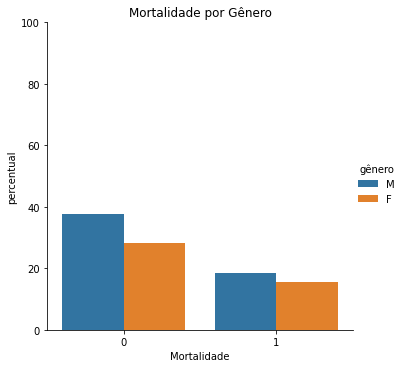

In [269]:

ax = sns.catplot(data=gs_df, x='mortalidade', y='percentual', kind='bar', hue='gênero')
ax.set(title ="Mortalidade por Gênero", xlabel='Mortalidade', ylim=(0,100))
# legend_labels, _= ax.get_legend_handles_labels()
# ax.legend(legend_labels, ['Feminino', 'Masculino'], bbox_to_anchor=(1,1), title='Gênero')

ax

<AxesSubplot:title={'center':'Mortalidade por Gênero'}, xlabel='Mortalidade'>

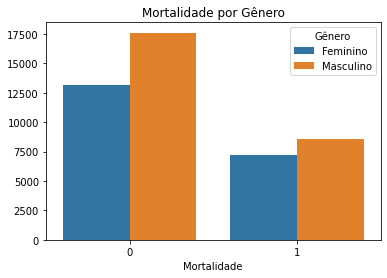

In [267]:
ax = sns.countplot(x="EXPIRE_FLAG", data=patients_df, hue='GENDER')
legend_labels, _= ax.get_legend_handles_labels()
ax.legend(legend_labels, ['Feminino', 'Masculino'], bbox_to_anchor=(1,1), title='Gênero')
ax.set_xlabel("Mortalidade")
ax.set_title("Mortalidade por Gênero")
ax.set_ylabel(None)
ax

A maioria dos pacientes sobrevive e dentre eles os homens são maioria.

**Pergunta:** Essas taxas de sobrevivência são confiáveis? Qual a idade destes pacientes?

### Atendimentos

In [237]:
# , usecols=['SUBJECT_ID', 'GENDER', 'DOB', 'EXPIRE_FLAG']
admissions = pd.read_csv('C:\csvMimic\\v1_4\ADMISSIONS.csv')
admissions.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


In [310]:
admissions['INSURANCE'].unique()

array(['Private', 'Medicare', 'Medicaid', 'Self Pay', 'Government'],
      dtype=object)

In [238]:
admissions.columns

Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
       'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS',
       'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA'],
      dtype='object')

Tipos de Atendimento

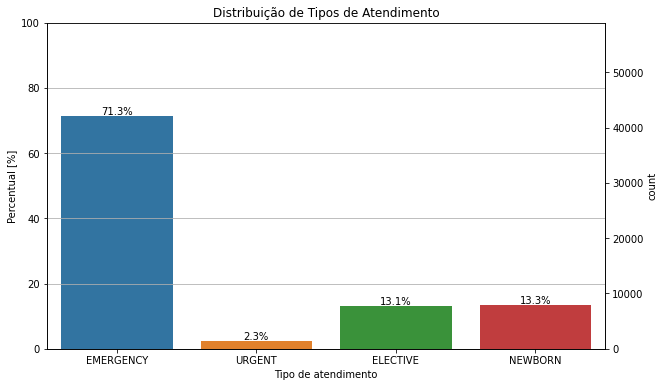

In [272]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.ticker as ticker

ncount = len(admissions)
plt.figure(figsize=(10,6))
ax = sns.countplot(x="ADMISSION_TYPE", data=admissions, order=['EMERGENCY', 'URGENT', 'ELECTIVE', 'NEWBORN'])
plt.title('Distribuição de Tipos de Atendimento')
plt.xlabel('Tipo de atendimento')

# Make twin axis
ax2=ax.twinx()

# Switch so count axis is on right, frequency on left
ax2.yaxis.tick_left()
ax.yaxis.tick_right()

# Also switch the labels over
ax.yaxis.set_label_position('right')
ax2.yaxis.set_label_position('left')

ax2.set_ylabel('Percentual [%]')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text

# Use a LinearLocator to ensure the correct number of ticks
# ax.yaxis.set_major_locator(ticker.LinearLocator(11))

# Fix the frequency range to 0-100
ax2.set_ylim(0, 100)
ax.set_ylim(0, ncount)

# And use a MultipleLocator to ensure a tick spacing of 10
# ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))

# Need to turn the grid on ax2 off, otherwise the gridlines end up on top of the bars
ax2.grid(None)

<AxesSubplot:xlabel='ADMISSION_TYPE', ylabel='count'>

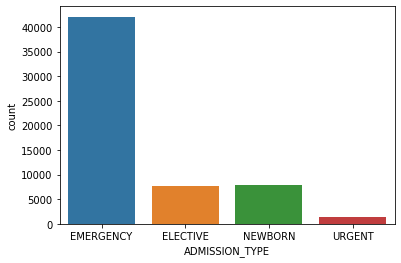

In [244]:
ax = sns.countplot(x="ADMISSION_TYPE", data=admissions)
legend_labels, _= ax.get_legend_handles_labels()
# ax.legend(legend_labels, ['Feminino', 'Masculino'], bbox_to_anchor=(1,1), title='Gênero')
# ax.set_xlabel("Mortalidade")
# ax.set_title("Mortalidade por Gênero")
# ax.set_ylabel(None)
ax

Distribuição dos pacientes por idade

Os pacientes foram divididos em 3 grupos etários:
- Com idade de 0 a 1 ano : *neonate*
- Com idade acima entre 14 e 89 anos: *adult*
- Acima de 89 anos: *>89*

Observação: Não foram realizados atendimentos em indivíduos entre 2 e 13 anos, por isso estas idades não são contempladas por nenhuma faixa.

Todas as datas na base incluindo a data de nascimento dos pacientes foi alterada para datas randômicas (no passado e no futuro) para resguardar a privacidade das pessoas envolvidas. Para se obter a idade foi efetuado o cálculo via query SQL da diferença entre a data de nascimento e a data do primeiro atendimento do paciente.

In [282]:
patients_by_age = pd.read_csv('C:\csvMimic\\pacientes-por-idades.csv')
patients_by_age.head()

,subject_id,dob,gender,first_admittime,first_admit_age,age_group
0,2,2138-07-17 00:00:00,M,2138-07-17 19:04:00,0.00,neonate
1,3,2025-04-11 00:00:00,M,2101-10-20 19:08:00,76.52,adult
2,4,2143-05-12 00:00:00,F,2191-03-16 00:28:00,47.84,adult
3,5,2103-02-02 00:00:00,M,2103-02-02 04:31:00,0.00,neonate
4,6,2109-06-21 00:00:00,F,2175-05-30 07:15:00,65.94,adult



Os pacientes com idade superior a 89 anos tiveram a idade alterada para 300 na base do MIMIC-III.

In [305]:
patients_by_age2 = pd.read_csv('C:\csvMimic\\pacientes-por-idades-2.csv')
patients_by_age2.head()

,subject_id,dob,gender,first_admittime,first_admit_age,expire_flag,age_group
0,2,2138-07-17 00:00:00,M,2138-07-17 19:04:00,0.00,0,neonate
1,3,2025-04-11 00:00:00,M,2101-10-20 19:08:00,76.52,1,adult
2,4,2143-05-12 00:00:00,F,2191-03-16 00:28:00,47.84,0,adult
3,5,2103-02-02 00:00:00,M,2103-02-02 04:31:00,0.00,0,neonate
4,6,2109-06-21 00:00:00,F,2175-05-30 07:15:00,65.94,0,adult


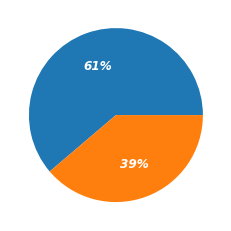

In [321]:
labels_mortality = ['Vivos', 'Mortos']
adults_df2 = patients_by_age2.query('first_admit_age > 1 and first_admit_age < 90')

plt.pie(adults_df2['expire_flag'].value_counts(), autopct='%.0f%%', labels = labels_mortality, textprops={'fontsize': 12, 'color': 'white', 'style': 'oblique', 'weight': 'bold'})
plt.show()

In [319]:
n_rows = adults_df2.shape[0]
gender_survival2 = pd.DataFrame(data=adults_df2['expire_flag'].value_counts().reset_index(name='total'))
gender_survival2['percentual'] = (gender_survival2['total'] / n_rows * 100).round(2)
gender_survival2.rename(columns={'index': 'mortalidade'}, inplace=True)
gender_survival2

,mortalidade,total,percentual
0,0,22442,61.22
1,1,14213,38.78


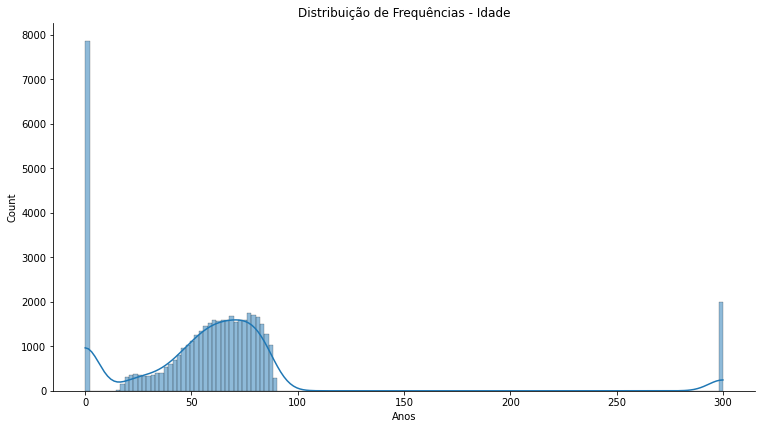

In [284]:
ax = sns.displot(patients_by_age.first_admit_age, kde = True)
ax.figure.set_size_inches(12,6) 
ax.set(title ="Distribuição de Frequências - Idade", xlabel='Anos')
ax

Pelo histograma acima a presença de três grupos etários se torna ainda mais evidente. Abaixo, apenas para fins de comprovação, não temos na base pacientes com idade entre 2 e 13 anos.

In [292]:
patients_by_age.query('first_admit_age > 1 and first_admit_age < 14')

,subject_id,dob,gender,first_admittime,first_admit_age,age_group


Distribuição de idade - Pacientes adultos

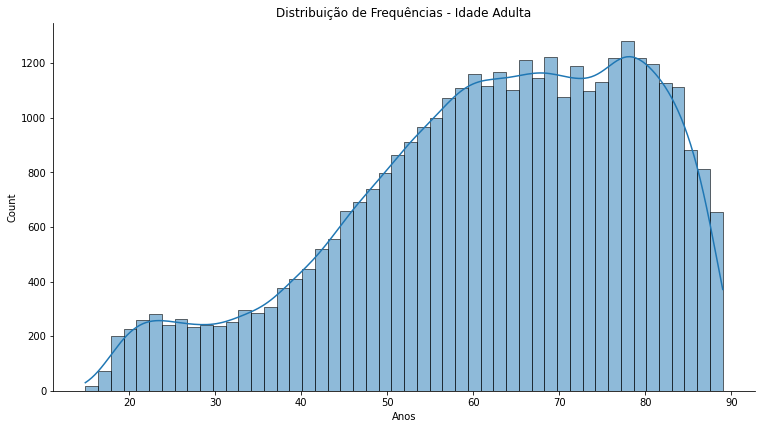

In [287]:
adults_df = patients_by_age.query('first_admit_age > 1 and first_admit_age < 90')

ax = sns.displot(adults_df.first_admit_age, kde = True)
ax.figure.set_size_inches(12,6) 
ax.set(title ="Distribuição de Frequências - Idade Adulta", xlabel='Anos')
ax

O intervalo de idades na faixa adulta é muito grande. Vamos plotar um boxplot das idades desta faixa para verificar mais claramente em que intervalo de idades estão concentrados a maior parte dos atendimentos.

<AxesSubplot:title={'center':'Idade - Grupo Adulto'}, xlabel='Anos', ylabel='Sexo'>

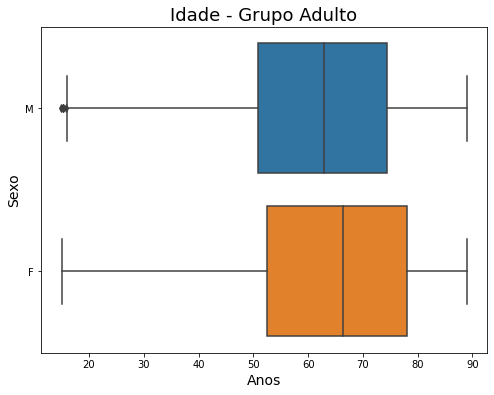

In [309]:
adults_df2 = patients_by_age2.query('first_admit_age > 1 and first_admit_age < 90')
ax = sns.boxplot(x = 'first_admit_age', y='gender', data=adults_df2)
ax.figure.set_size_inches(8,6)
ax.set_title('Idade - Grupo Adulto', fontsize=18)
ax.set_xlabel('Anos', fontsize=14)
ax.set_ylabel('Sexo', fontsize=14)
ax

<AxesSubplot:title={'center':'Idade - Grupo Adulto'}, xlabel='Anos', ylabel='Sexo'>

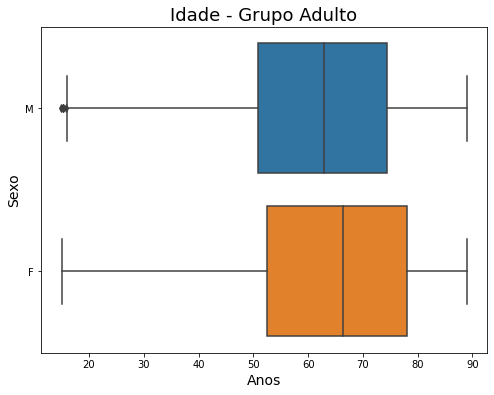

In [307]:
ax = sns.boxplot(x = 'first_admit_age', y='gender', data=adults_df)
ax.figure.set_size_inches(8,6)
ax.set_title('Idade - Grupo Adulto', fontsize=18)
ax.set_xlabel('Anos', fontsize=14)
ax.set_ylabel('Sexo', fontsize=14)
ax

Taxa de mortalidade por grupo etário

In [303]:
adults_df.columns

Index(['subject_id', 'dob', 'gender', 'first_admittime', 'first_admit_age',
       'age_group'],
      dtype='object')

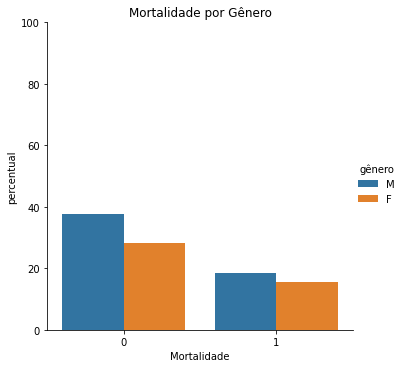

In [293]:
ax = sns.catplot(data=adults_df, x='mortalidade', y='percentual', kind='bar', hue='gênero')
ax.set(title ="Mortalidade por Gênero", xlabel='Mortalidade', ylim=(0,100))
# legend_labels, _= ax.get_legend_handles_labels()
# ax.legend(legend_labels, ['Feminino', 'Masculino'], bbox_to_anchor=(1,1), title='Gênero')

ax

In [242]:
admissions['ETHNICITY'].unique()

array(['WHITE', 'UNKNOWN/NOT SPECIFIED', 'MULTI RACE ETHNICITY',
       'BLACK/AFRICAN AMERICAN', 'HISPANIC OR LATINO',
       'PATIENT DECLINED TO ANSWER', 'ASIAN', 'OTHER',
       'HISPANIC/LATINO - GUATEMALAN', 'ASIAN - VIETNAMESE',
       'AMERICAN INDIAN/ALASKA NATIVE', 'WHITE - RUSSIAN',
       'HISPANIC/LATINO - PUERTO RICAN', 'ASIAN - CHINESE',
       'ASIAN - ASIAN INDIAN', 'BLACK/AFRICAN',
       'HISPANIC/LATINO - SALVADORAN', 'HISPANIC/LATINO - DOMINICAN',
       'UNABLE TO OBTAIN', 'BLACK/CAPE VERDEAN', 'BLACK/HAITIAN',
       'WHITE - OTHER EUROPEAN', 'PORTUGUESE', 'SOUTH AMERICAN',
       'WHITE - EASTERN EUROPEAN', 'CARIBBEAN ISLAND', 'ASIAN - FILIPINO',
       'ASIAN - CAMBODIAN', 'HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)',
       'WHITE - BRAZILIAN', 'ASIAN - KOREAN',
       'HISPANIC/LATINO - COLOMBIAN', 'ASIAN - JAPANESE',
       'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER', 'ASIAN - THAI',
       'HISPANIC/LATINO - HONDURAN', 'HISPANIC/LATINO - CUBAN',
       'MID

In [241]:
admissions['LANGUAGE'].unique()

array([nan, 'ENGL', 'VIET', 'PORT', 'MAND', 'CANT', 'SPAN', 'RUSS',
       'CAPE', '*MAN', 'PTUN', 'HIND', 'ITAL', 'HAIT', 'GREE', 'CAMB',
       '*ARM', '*CHI', 'ALBA', '*DEA', 'POLI', 'FREN', 'ARAB', 'AMER',
       'LAOT', '*PUN', '*URD', '*BUR', '*BEN', '*TOY', '*HUN', 'KORE',
       'THAI', 'PERS', 'ETHI', 'JAPA', '*PHI', '*IBO', '*LEB', '*FUL',
       'URDU', '*SPA', '*RUS', 'SOMA', '* BE', '*CAN', '*CDI', 'TURK',
       '*TOI', 'GERM', '*GUJ', '*BOS', '*BUL', '*TEL', '*YID', '*ROM',
       '**TO', 'BENG', '*AMH', 'TAGA', '* FU', '*MOR', '*ARA', '*YOR',
       '*FAR', '*DUT', 'SERB', '*KHM', '** T', '*NEP', '*CRE', '*FIL',
       '*LIT', '*PER', '**SH', '*TAM'], dtype=object)

In [239]:
admissions['RELIGION'].unique()

array(['UNOBTAINABLE', 'CATHOLIC', 'PROTESTANT QUAKER', 'NOT SPECIFIED',
       'JEWISH', 'BUDDHIST', 'OTHER', "JEHOVAH'S WITNESS", nan,
       'GREEK ORTHODOX', 'EPISCOPALIAN', 'HINDU', 'CHRISTIAN SCIENTIST',
       'HEBREW', 'METHODIST', 'UNITARIAN-UNIVERSALIST', 'BAPTIST',
       '7TH DAY ADVENTIST', 'MUSLIM', 'ROMANIAN EAST. ORTH', 'LUTHERAN'],
      dtype=object)

In [240]:
admissions['MARITAL_STATUS'].unique()

array(['MARRIED', 'SINGLE', nan, 'DIVORCED', 'WIDOWED', 'SEPARATED',
       'UNKNOWN (DEFAULT)', 'LIFE PARTNER'], dtype=object)

Primeiros questionamentos:

Quantos pacientes diferentes temos na base do MIMIC-3?
Qual a taxa de recuperação destes pacientes?
Como é essa população de pacientes? Gênero, idade, renda, ocupação.
Qual doença gera mais internações?
Qual doença gera mais internações reincidentes?
Quais os maiores motivos de entrada na emergência?
Quais doenças geram mais mortes?

Informações importantes:
Período de admissões nos hospitais: 01/06/2001 a 10/10/2012
Número de atendimentos: 58976
Número de pacientes atendidos: 46.520
- Mulheres: 20399
- Homens: 26121

Atributos importantes da base:

tabela PATIENTS:
- subject_id [UK]
- gender
- dob (day of birth)
- expire_flag (morreu?)

tabela ADMISSIONS:
- hadm_id [UK]
- ADMITTIME
- DISCHTIME
- ADMISSION_TYPE
- 

In [12]:
print('oi')

oi
